In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService
import os
n_jobs = 16
os.environ["OMP_NUM_THREADS"] = str(n_jobs)
import joblib
import click
import json
import time
from glob import glob
import itertools
import collections.abc
import sys
from tqdm.notebook import tqdm
# !{sys.executable} -m pip install qcircuit

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pennylane as qml
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import re
from joblib import Parallel, delayed, dump, load


In [2]:
top=os.getcwd()
with open(os.path.join(top,'5_DDCC_train.bin'),'rb') as f:
    ddcc_train = joblib.load(f)

with open(os.path.join(top,'5_DDCC_test.bin'),'rb') as f:
    ddcc_test = joblib.load(f)

with open(os.path.join(top,'5_DDCC_scaler.bin'),'rb') as f:
    ddcc_scaler = joblib.load(f)

X_ddcc_train, y_ddcc_train = ddcc_train['X'],ddcc_train['y']
X_ddcc_test, y_ddcc_test = ddcc_test['X'],ddcc_test['y']

X_ddcc_train = X_ddcc_train.reshape(-1,64,5)[0:4]
X_ddcc_test = X_ddcc_test.reshape(-1,64,5)[0:4]
y_ddcc_train = y_ddcc_train.reshape(-1,64)[0:4]
y_ddcc_test = y_ddcc_test.reshape(-1,64)[0:4]


# X_train, y_train = X_ddcc_train, y_ddcc_train
# X_test, y_test = X_ddcc_test, y_ddcc_test
X_train, y_train = X_ddcc_train, y_ddcc_train
X_test, y_test = X_ddcc_test, y_ddcc_test

# X_train = [X_train[i:i+4] for i in range(0,len(X_train),4)]
# X_test = [X_test[i:i+4] for i in range(0,len(X_test),4)]
scaler = ddcc_scaler

# print(len(X_train),X_train[0].shape,X_train[-1].shape)
print(y_train.shape, y_test.shape)

(4, 64) (4, 64)


/home/grierjones/miniconda3/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
def grab_data(path):
    '''
    Given a globbed path, return the job_n.txt, *_train.txt, and *_test.txt files
    '''
    iterations = []
    train_metric = []
    test_metric = []
    for i in path:
        try:
            numbers = int(re.search(r'jobs_(\d+)\.txt', i).group(1))
            iterations.append(i)
        except:
            if 'test' in i:
                test_metric.append(i)
            else:
                train_metric.append(i)
            
    return sorted(iterations,key=lambda x: int(re.search(r'jobs_(\d+)\.txt', x).group(1))), train_metric, test_metric

In [4]:
def fetch_jobs_from_file(service, filename):
    """Fetch all job results from a given file."""
    with open(filename, 'r') as f:
        job_ids = f.readlines()
    return [service.job(job_id.strip()).result() for job_id in job_ids]

def grab_jobs(lst):
    """Parallelize over job files, fetching results concurrently."""
    service = QiskitRuntimeService(
        channel='ibm_quantum',
        instance='pinq-quebec-hub/univ-toronto/default'
    )

    # Parallel processing of files
    jobs = Parallel(n_jobs=-1,backend='threading')(
        delayed(fetch_jobs_from_file)(service, filename) for filename in tqdm(lst)
    )

    return np.array(jobs)

In [5]:
iter_100, train_100, test_100 = grab_data(glob('100_iter/*txt'))
iter_500, train_500, test_500 = grab_data(glob('500_iter/*txt'))
iter_1000, train_1000, test_1000 = grab_data(glob('1000_iter/*txt'))

In [6]:
# results_100 = grab_jobs(iter_100)
# y_100 = np.array([[[k.data.evs.flatten() for k in j] for j in i] for i in results_100]).reshape(*results_100.shape)


# results_500 = grab_jobs(iter_500)
# y_500 = np.array([[[k.data.evs.flatten() for k in j] for j in i] for i in results_500]).reshape(*results_500.shape)

# results_1000 = grab_jobs(iter_1000)
# y_1000 = np.array([[[k.data.evs.flatten() for k in j] for j in i] for i in results_1000]).reshape(*results_1000.shape)
# with open('y_100.npy', 'wb') as f:
#     np.save(f, y_100)
# with open('y_500.npy', 'wb') as f:
#     np.save(f, y_500)
# with open('y_1000.npy', 'wb') as f:
#     np.save(f, y_1000)

# results_train_100 = grab_jobs(train_100)
# y_100_train = np.array([[[k.data.evs.flatten() for k in j] for j in i] for i in results_train_100]).reshape(*y_train.shape)


# results_train_500 = grab_jobs(train_500)
# y_500_train = np.array([[[k.data.evs.flatten() for k in j] for j in i] for i in results_train_500]).reshape(*y_train.shape)

# results_train_1000 = grab_jobs(train_1000)
# y_1000_train = np.array([[[k.data.evs.flatten() for k in j] for j in i] for i in results_train_1000]).reshape(*y_train.shape)

# results_test_100 = grab_jobs(test_100)
# y_100_test = np.array([[[k.data.evs.flatten() for k in j] for j in i] for i in results_test_100]).reshape(*y_test.shape)


# results_test_500 = grab_jobs(test_500)
# y_500_test = np.array([[[k.data.evs.flatten() for k in j] for j in i] for i in results_test_500]).reshape(*y_test.shape)

# results_test_1000 = grab_jobs(test_1000)
# y_1000_test = np.array([[[k.data.evs.flatten() for k in j] for j in i] for i in results_test_1000]).reshape(*y_test.shape)

# with open('y_100_test.npy', 'wb') as f:
#     np.save(f, y_100_test)
# with open('y_500_test.npy', 'wb') as f:
#     np.save(f, y_500_test)
# with open('y_1000_test.npy', 'wb') as f:
#     np.save(f, y_1000_test)


# with open('y_100_train.npy', 'wb') as f:
#     np.save(f, y_100_train)
# with open('y_500_train.npy', 'wb') as f:
#     np.save(f, y_500_train)
# with open('y_1000_train.npy', 'wb') as f:
#     np.save(f, y_1000_train)

In [7]:


with open('y_100_test.npy', 'rb') as f:
    y_100_test = np.load(f)
with open('y_500_test.npy', 'rb') as f:
    y_500_test = np.load(f)
with open('y_1000_test.npy', 'rb') as f:
    y_1000_test = np.load(f)   


    
with open('y_100_train.npy', 'rb') as f:
    y_100_train = np.load(f)
with open('y_500_train.npy', 'rb') as f:
    y_500_train = np.load(f)
with open('y_1000_train.npy', 'rb') as f:
    y_1000_train = np.load(f)       
    
with open('y_100.npy', 'rb') as f:
    y_100 = np.load(f)
with open('y_500.npy', 'rb') as f:
    y_500 = np.load(f)
with open('y_1000.npy', 'rb') as f:
    y_1000 = np.load(f)    
    


In [8]:
r2_score(y_ddcc_train.flatten(),y_100_train.flatten())

-0.17153119703559372

In [9]:
r2_score(y_ddcc_train.flatten(),y_500_train.flatten())

0.28885572258977765

In [10]:
r2_score(y_ddcc_train.flatten(),y_1000_train.flatten())

0.2137649236682102

In [11]:
MSE_100 = [mean_squared_error(y_ddcc_train.flatten(),i.flatten()) for i in y_100]
MSE_500 = [mean_squared_error(y_ddcc_train.flatten(),i.flatten()) for i in y_500]
MSE_1000 = [mean_squared_error(y_ddcc_train.flatten(),i.flatten()) for i in y_1000]

In [12]:
best_train = np.vstack([y_100,y_500,y_1000])[np.argmin(MSE_100+MSE_500+MSE_1000)]

In [13]:
r2_score(y_ddcc_train.flatten(),best_train.flatten())

0.3045004545007308

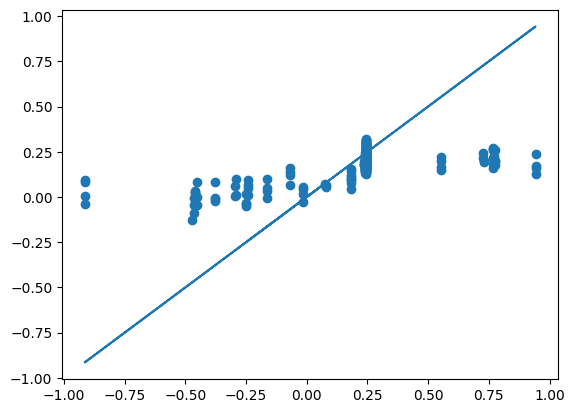

In [14]:
plt.scatter(y_ddcc_train.flatten(),best_train.flatten())
plt.plot(y_ddcc_train.flatten(),y_ddcc_train.flatten())

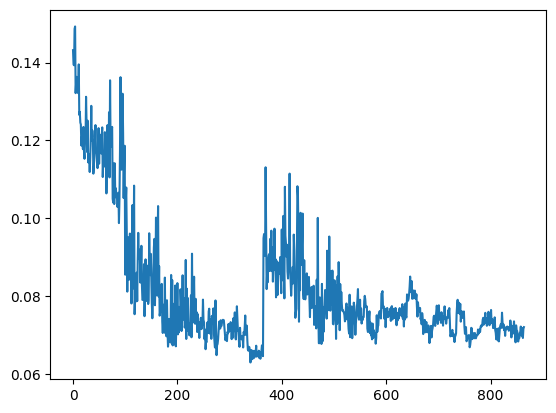

In [15]:
plt.plot(MSE_100+MSE_500+MSE_1000)